In [2]:
import pickle
import pandas as pd
import numpy as np
from sklearn.metrics import precision_recall_curve, roc_auc_score, confusion_matrix, precision_score, recall_score
from sklearn.model_selection import KFold, StratifiedKFold
from scipy.stats.mstats import gmean
import xgboost as xgb
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
fpath = "/Users/ys8mz/Box Sync/Predictive Models of College Completion (VCCS)/intermediate_files"

In [3]:
df = pd.read_stata(fpath + "/full_data_truncated.dta")

In [4]:
demo_predictors = ["age_entry", "male", "white", "afam", "hisp", "other", "pell_0_ind", "pell_1_ind"] + \
["pell_0_" + s1 + str(s2) for s1 in ["fa","sp","su"] for s2 in range(1,7)] + \
["pell_1_" + s1 + str(s2) for s1 in ["fa","sp","su"] for s2 in range(1,7)] + \
["phe_" + str(i) for i in range(1,8)]
demo_predictors = set(demo_predictors)
predictors = [p for p in list(df.columns)[10:] if p not in demo_predictors]
print(len(predictors), len(demo_predictors))

280 51


In [5]:
impute_list_1 = set(["prop_comp_pre","cum_gpa_pre"])
impute_list_2 = set([t1+"_"+t2+str(t3) for t1 in ["term_gpa", "prop_comp", "lvl2_prop_comp", "dev_prop_comp"] for t2 in ["fa", "sp", "su"] for t3 in range(1,7,1)])
impute_list_3 = set(["cum_gpa", "lvl2_prop_comp", "dev_prop_comp", "prop_comp", "prop_comp_sd", "withdrawn_prop_comp_sd"])
impute_list_4 = set(["admrate", "gradrate", "satvr25", "satvr75", "satmt25", "satmt75", "satwr25", "satwr75"])

In [6]:
train_df = df[df.valid == 0]
test_df = df[df.valid == 1]
print(train_df.shape,test_df.shape)

(298139, 341) (33115, 341)


In [7]:
def impute(train, test):
    for p in impute_list_1:
        avg_p = np.nanmean(train[train.enrolled_pre == 1][p])
        train.loc[:,p] = train.loc[:,p].apply(lambda x: avg_p if pd.isnull(x) else x)
        test.loc[:,p] = test.loc[:,p].apply(lambda x: avg_p if pd.isnull(x) else x)
    for p in impute_list_3:
        avg_p = np.nanmean(train[p])
        train.loc[:,p] = train.loc[:,p].apply(lambda x: avg_p if pd.isnull(x) else x)
        test.loc[:,p] = test.loc[:,p].apply(lambda x: avg_p if pd.isnull(x) else x)
    for p in impute_list_2:
        suffix = p[-3:]
        avg_p = np.nanmean(train[train["enrolled_" + suffix] == 1][p])
        train.loc[:,p] = train.loc[:,p].apply(lambda x: avg_p if pd.isnull(x) else x)
        test.loc[:,p] = test.loc[:,p].apply(lambda x: avg_p if pd.isnull(x) else x)
    for p in impute_list_4:
        avg_p = np.nanmean(train[train["enrolled_nsc"] == 1][p])
        train.loc[:,p] = train.loc[:,p].apply(lambda x: avg_p if pd.isnull(x) else x)
        test.loc[:,p] = test.loc[:,p].apply(lambda x: avg_p if pd.isnull(x) else x)
    return train, test 

In [8]:
train_df_new, test_df_new = impute(train_df, test_df)
X_train = train_df_new.loc[:,predictors]
y_train = train_df_new.grad_6years
X_test = test_df_new.loc[:,predictors]
y_test = test_df_new.grad_6years

C:\Users\ys8mz\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [9]:
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)

In [10]:
np.random.seed(4321)
val_indices = np.random.choice(train_df.shape[0], int(np.floor(train_df.shape[0]*0.15)), replace=False)
train_val = train_df.iloc[val_indices,:]
train_train = train_df.iloc[np.setdiff1d(np.arange(train_df.shape[0]), val_indices),:]
train_train_new, train_val_new = impute(train_train, train_val)
X_train_train = train_train_new.loc[:,predictors]
y_train_train = train_train_new.grad_6years
X_train_val = train_val_new.loc[:,predictors]
y_train_val = train_val_new.grad_6years

C:\Users\ys8mz\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [11]:
dtrain_train = xgb.DMatrix(X_train_train, y_train_train)
dtrain_val = xgb.DMatrix(X_train_val, y_train_val)

In [12]:
results_dir = "C:\\Users\\ys8mz\\Box Sync\\Predictive Models of College Completion (VCCS)\\evaluation_results\\truncated_without_demo\\"

#### (1) Grid Search for max_depth and eta (learning rate)

In [12]:
grid_1 = [(md,e) for md in range(4,8) for e in [0.01, 0.02, 0.05, 0.1, 0.2]]
validation_auc_1 = Counter()
for md,e in grid_1:
    print("max_depth = {0}, eta = {1}:".format(md,e))
    params = {'max_depth': md, 'eta': e, 'min_child_weight': 1, 'colsample_bytree': 0.8, 
              'subsample': 0.8, 
              'objective': 'binary:logistic', 'eval_metric': ['auc'],
              'seed': 12345}
    evals_result = {}
    xgb_model = xgb.train(params = params, dtrain = dtrain_train, num_boost_round = int(5e3), evals = [(dtrain_val, 'validation')],
                          early_stopping_rounds = 10,
                          evals_result = evals_result,
                          verbose_eval = 50)
    validation_auc_1[(md,e)] = np.max(evals_result['validation']['auc'])
    print("")

max_depth = 4, eta = 0.01:
[0]	validation-auc:0.815242
Will train until validation-auc hasn't improved in 10 rounds.
Stopping. Best iteration:
[21]	validation-auc:0.846488


max_depth = 4, eta = 0.02:
[0]	validation-auc:0.815242
Will train until validation-auc hasn't improved in 10 rounds.
[50]	validation-auc:0.85454
[100]	validation-auc:0.863548
[150]	validation-auc:0.869789
[200]	validation-auc:0.874123
[250]	validation-auc:0.87693
[300]	validation-auc:0.879151
[350]	validation-auc:0.880929
[400]	validation-auc:0.882261
[450]	validation-auc:0.883446
[500]	validation-auc:0.884466
[550]	validation-auc:0.885237
[600]	validation-auc:0.885961
[650]	validation-auc:0.886586
[700]	validation-auc:0.887085
[750]	validation-auc:0.88755
[800]	validation-auc:0.888013
[850]	validation-auc:0.888401
[900]	validation-auc:0.888756
[950]	validation-auc:0.88908
[1000]	validation-auc:0.889342
[1050]	validation-auc:0.889584
[1100]	validation-auc:0.889863
[1150]	validation-auc:0.8901
[1200]	validation-auc:

[200]	validation-auc:0.891763
[250]	validation-auc:0.892559
[300]	validation-auc:0.893075
[350]	validation-auc:0.893561
[400]	validation-auc:0.894006
[450]	validation-auc:0.894192
[500]	validation-auc:0.894394
Stopping. Best iteration:
[505]	validation-auc:0.894425


max_depth = 5, eta = 0.2:
[0]	validation-auc:0.828533
Will train until validation-auc hasn't improved in 10 rounds.
[50]	validation-auc:0.88735
[100]	validation-auc:0.890857
[150]	validation-auc:0.891927
Stopping. Best iteration:
[180]	validation-auc:0.892388


max_depth = 6, eta = 0.01:
[0]	validation-auc:0.837279
Will train until validation-auc hasn't improved in 10 rounds.
[50]	validation-auc:0.865026
[100]	validation-auc:0.869205
[150]	validation-auc:0.872482
[200]	validation-auc:0.875195
[250]	validation-auc:0.877569
[300]	validation-auc:0.879518
[350]	validation-auc:0.881147
[400]	validation-auc:0.882596
[450]	validation-auc:0.883853
[500]	validation-auc:0.884971
[550]	validation-auc:0.885994
[600]	validation-auc:0.8

[350]	validation-auc:0.894651
[400]	validation-auc:0.894904
Stopping. Best iteration:
[398]	validation-auc:0.894925


max_depth = 7, eta = 0.2:
[0]	validation-auc:0.844291
Will train until validation-auc hasn't improved in 10 rounds.
[50]	validation-auc:0.890773
[100]	validation-auc:0.892542
[150]	validation-auc:0.893
Stopping. Best iteration:
[161]	validation-auc:0.893087




In [13]:
for t in validation_auc_1.most_common():
    print(t)

((7, 0.01), 0.896028)
((7, 0.02), 0.895622)
((6, 0.01), 0.895485)
((6, 0.02), 0.895111)
((7, 0.05), 0.894952)
((7, 0.1), 0.894925)
((5, 0.05), 0.894834)
((6, 0.05), 0.89465)
((5, 0.02), 0.894451)
((5, 0.1), 0.894425)
((5, 0.01), 0.894389)
((6, 0.1), 0.894302)
((4, 0.02), 0.893672)
((4, 0.05), 0.893449)
((6, 0.2), 0.893212)
((7, 0.2), 0.893087)
((4, 0.2), 0.892915)
((4, 0.1), 0.892803)
((5, 0.2), 0.892388)
((4, 0.01), 0.846488)


#### (2) Grid Search for min_child_weight (along with max_depth)

In [14]:
md1 = 6
grid_2 = [(md1+i,mcw) for i in [-1,0,1] for mcw in [3,5]]
validation_auc_2 = Counter()
for md,mcw in grid_2:
    print("max_depth = {0}, min_child_weight = {1}:".format(md,mcw))
    params = {'max_depth': md, 'eta': 0.02, 'min_child_weight': mcw, 'colsample_bytree': 0.8, 
              'subsample': 0.8, 
              'objective': 'binary:logistic', 'eval_metric': ['auc'],
              'seed': 12345}
    evals_result = {}
    xgb_model = xgb.train(params = params, dtrain = dtrain_train, num_boost_round = int(5e3), evals = [(dtrain_val, 'validation')],
                          early_stopping_rounds = 10,
                          evals_result = evals_result,
                          verbose_eval = 50)
    validation_auc_2[(md,mcw)] = np.max(evals_result['validation']['auc'])
    print("")

max_depth = 5, min_child_weight = 3:
[0]	validation-auc:0.828533
Will train until validation-auc hasn't improved in 10 rounds.
[50]	validation-auc:0.862859
[100]	validation-auc:0.87039
[150]	validation-auc:0.875349
[200]	validation-auc:0.878916
[250]	validation-auc:0.881495
[300]	validation-auc:0.883579
[350]	validation-auc:0.885224
[400]	validation-auc:0.88646
[450]	validation-auc:0.88739
[500]	validation-auc:0.888131
[550]	validation-auc:0.888819
[600]	validation-auc:0.889407
[650]	validation-auc:0.889967
[700]	validation-auc:0.890323
[750]	validation-auc:0.890761
[800]	validation-auc:0.891115
[850]	validation-auc:0.891396
[900]	validation-auc:0.891655
[950]	validation-auc:0.891912
[1000]	validation-auc:0.892159
[1050]	validation-auc:0.892382
[1100]	validation-auc:0.892583
[1150]	validation-auc:0.892746
[1200]	validation-auc:0.89294
[1250]	validation-auc:0.893115
[1300]	validation-auc:0.893283
[1350]	validation-auc:0.893399
[1400]	validation-auc:0.893521
[1450]	validation-auc:0.89364

In [15]:
for t in validation_auc_2.most_common():
    print(t)

((7, 3), 0.895906)
((7, 5), 0.895615)
((6, 3), 0.895273)
((6, 5), 0.894907)
((5, 3), 0.894795)
((5, 5), 0.894385)


#### (3) Grid Search for colsample_by_tree

In [16]:
grid_3 = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]
validation_auc_3 = Counter()
for cbt in grid_3:
    print("colsample_by_tree = {}:".format(cbt))
    params = {'max_depth': 7, 'eta': 0.02, 'min_child_weight': 3, 'colsample_bytree': cbt, 
              'subsample': 0.8, 
              'objective': 'binary:logistic', 'eval_metric': ['auc'],
              'seed': 12345}
    evals_result = {}
    xgb_model = xgb.train(params = params, dtrain = dtrain_train, num_boost_round = int(5e3), evals = [(dtrain_val, 'validation')],
                          early_stopping_rounds = 10,
                          evals_result = evals_result,
                          verbose_eval = 50)
    validation_auc_3[cbt] = np.max(evals_result['validation']['auc'])
    print("")

colsample_by_tree = 0.5:
[0]	validation-auc:0.827185
Will train until validation-auc hasn't improved in 10 rounds.
[50]	validation-auc:0.87571
[100]	validation-auc:0.879822
[150]	validation-auc:0.882896
[200]	validation-auc:0.885254
[250]	validation-auc:0.887411
[300]	validation-auc:0.889192
[350]	validation-auc:0.890438
[400]	validation-auc:0.891354
[450]	validation-auc:0.892116
[500]	validation-auc:0.892683
[550]	validation-auc:0.893115
[600]	validation-auc:0.893454
[650]	validation-auc:0.893788
[700]	validation-auc:0.894022
[750]	validation-auc:0.894279
[800]	validation-auc:0.894511
[850]	validation-auc:0.894689
[900]	validation-auc:0.894884
[950]	validation-auc:0.895
[1000]	validation-auc:0.895165
[1050]	validation-auc:0.895303
[1100]	validation-auc:0.89545
[1150]	validation-auc:0.895562
[1200]	validation-auc:0.895677
[1250]	validation-auc:0.895749
[1300]	validation-auc:0.895848
[1350]	validation-auc:0.895973
[1400]	validation-auc:0.896073
[1450]	validation-auc:0.896178
[1500]	vali

[1200]	validation-auc:0.895578
Stopping. Best iteration:
[1221]	validation-auc:0.89564


colsample_by_tree = 0.9:
[0]	validation-auc:0.849439
Will train until validation-auc hasn't improved in 10 rounds.
[50]	validation-auc:0.873004
[100]	validation-auc:0.878592
[150]	validation-auc:0.882377
[200]	validation-auc:0.885222
[250]	validation-auc:0.887517
[300]	validation-auc:0.889163
[350]	validation-auc:0.890383
[400]	validation-auc:0.891224
[450]	validation-auc:0.891942
[500]	validation-auc:0.892492
[550]	validation-auc:0.892863
[600]	validation-auc:0.893267
[650]	validation-auc:0.893589
[700]	validation-auc:0.893844
[750]	validation-auc:0.894117
[800]	validation-auc:0.894353
[850]	validation-auc:0.894582
[900]	validation-auc:0.894769
[950]	validation-auc:0.894969
[1000]	validation-auc:0.89512
[1050]	validation-auc:0.895253
[1100]	validation-auc:0.895379
[1150]	validation-auc:0.895475
[1200]	validation-auc:0.89561
[1250]	validation-auc:0.895702
[1300]	validation-auc:0.895791
[1350]	valid

In [17]:
validation_auc_3.most_common()

[(0.65, 0.896359),
 (0.5, 0.896312),
 (0.6, 0.896228),
 (0.7, 0.89622),
 (0.75, 0.896186),
 (0.9, 0.895988),
 (0.55, 0.895956),
 (0.8, 0.895906),
 (0.85, 0.89564)]

#### (4) Finally select the opitmal num_boost_round

In [18]:
params = {'max_depth': 7, 'eta': 0.02, 'min_child_weight': 3, 'colsample_bytree': 0.65, 
          'subsample': 0.8, 
          'objective': 'binary:logistic', 'eval_metric': ['auc'],
          'seed': 12345}
evals_result = {}
xgb_model = xgb.train(params = params, dtrain = dtrain_train, num_boost_round = int(5e3), evals = [(dtrain_val, 'validation')],
                      early_stopping_rounds = 10,
                      evals_result = evals_result,
                      verbose_eval = 50)
optimal_num_boost_round = np.argmax(evals_result['validation']['auc'])
print("")
print(optimal_num_boost_round)

[0]	validation-auc:0.842699
Will train until validation-auc hasn't improved in 10 rounds.
[50]	validation-auc:0.874772
[100]	validation-auc:0.879361
[150]	validation-auc:0.882745
[200]	validation-auc:0.885349
[250]	validation-auc:0.887552
[300]	validation-auc:0.889292
[350]	validation-auc:0.890556
[400]	validation-auc:0.891432
[450]	validation-auc:0.892108
[500]	validation-auc:0.892709
[550]	validation-auc:0.893143
[600]	validation-auc:0.893464
[650]	validation-auc:0.893819
[700]	validation-auc:0.894091
[750]	validation-auc:0.894314
[800]	validation-auc:0.894542
[850]	validation-auc:0.894759
[900]	validation-auc:0.894914
[950]	validation-auc:0.895051
[1000]	validation-auc:0.895252
[1050]	validation-auc:0.895376
[1100]	validation-auc:0.895514
[1150]	validation-auc:0.895605
[1200]	validation-auc:0.895734
[1250]	validation-auc:0.895811
[1300]	validation-auc:0.895924
[1350]	validation-auc:0.896023
[1400]	validation-auc:0.896125
[1450]	validation-auc:0.896205
[1500]	validation-auc:0.896263


#### (5) Train the final xgb model and make predictions for observations in the test set

In [19]:
# specify parameters via map
params = {'max_depth': 7, 'eta': 0.02, 'min_child_weight': 3, 'colsample_bytree': 0.65, 
          'subsample': 0.8, 
          'objective': 'binary:logistic', 'eval_metric': ['auc'],
          'seed': 12345}
final_xgb_model = xgb.train(params = params, dtrain = dtrain, num_boost_round = optimal_num_boost_round)
# make prediction for observations in the test set
y_test_pred = final_xgb_model.predict(dtest)

In [20]:
print("XGBoost:")
print("AUC = {}".format(round(roc_auc_score(dtest.get_label(), y_test_pred), 4)))

XGBoost:
AUC = 0.9001


In [21]:
# save the model object and predicted scores on the validation sample to local disk
# pickle.dump(final_xgb_model, open(results_dir + "/xgb.p", "wb"))
pickle.dump(list(y_test_pred), open(results_dir + "/y_test_pred_xgb.p", "wb"))

In [22]:
feature_importance = pd.DataFrame(list(final_xgb_model.get_fscore().items()), columns=['feature','importance']).sort_values('importance', ascending=False)
feature_importance.loc[:, 'importance'] = feature_importance.loc[:, 'importance'] / sum(feature_importance.loc[:, 'importance'])
yy = feature_importance.loc[:, 'importance'].iloc[:20]
xx = feature_importance.loc[:, 'feature'].iloc[:20]

In [23]:
xgb_summary = feature_importance.rename(columns = {'feature':'predictor_name',
                                                   'importance':'feature_importance'})\
.loc[:,['predictor_name', 'feature_importance']]
xgb_summary = xgb_summary.merge(pd.DataFrame({'predictor_name': predictors}), on=['predictor_name'], how='right')\
.sort_values(['feature_importance', 'predictor_name'], ascending=[False, True]).fillna(0)
xgb_summary.to_csv(results_dir + "xgb_summary.csv", index=False)

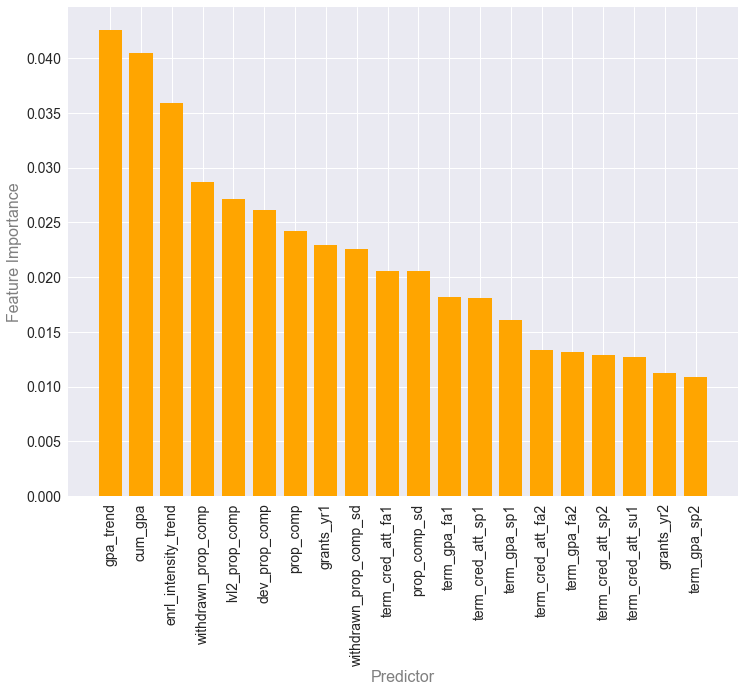

In [24]:
fig = plt.figure(figsize=(12,9))
plt.bar(list(range(20)), yy, width=0.75, color = "orange")
plt.xticks(list(range(20)), xx, rotation = 'vertical', fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Predictor", fontsize=16, color="gray")
plt.ylabel("Feature Importance", fontsize=16, color="gray")
plt.savefig(results_dir + "XGBoost_variable_importance.png", bbox_inches='tight')
plt.show()

In [25]:
def find_optimal_threshold(p,r,t):
    to_drop = np.union1d(np.where(pd.isnull(p[:-1]) == True)[0], np.where(pd.isnull(r[:-1]) == True)[0])
    to_drop = np.union1d(to_drop, np.where(pd.isnull(t) == True)[0])
    to_keep = np.setdiff1d(np.array(list(range(len(p)-1))), to_drop)
    p,r,t = p[to_keep],r[to_keep],t[to_keep]
    f1 = 2*p*r/(p+r)
    best_t = t[np.argmax(f1)]
    best_t
    return best_t

def cross_validation(train, xgb_params, nbr):
    threshold_list = []
    auc_list = []
    k_fold =  StratifiedKFold(n_splits = 10, random_state = 12345, shuffle=True)
    for train_indices, test_indices in k_fold.split(train, train.grad_6years):
        train_part = train.iloc[train_indices,:]
        test_part = train.iloc[test_indices,:]
        train_part_new, test_part_new = impute(train_part, test_part)
        X_1 = train_part_new.loc[:,predictors]
        y_1 = train_part_new.grad_6years
        X_2 = test_part_new.loc[:,predictors]
        y_2 = test_part_new.grad_6years
        dtrain_cv = xgb.DMatrix(X_1,y_1)
        dtest_cv = xgb.DMatrix(X_2,y_2)
        xgb_cv_model = xgb.train(params=xgb_params, dtrain=dtrain_cv, num_boost_round = nbr)
        y_2_pred = xgb_cv_model.predict(dtest_cv)
        p,r,t = precision_recall_curve(y_2, y_2_pred)
        auc = roc_auc_score(y_2, y_2_pred)
        threshold_list.append(find_optimal_threshold(p,r,t))
        auc_list.append(auc)
    print(np.mean(auc_list), np.std(auc_list, ddof=1))
    return gmean(threshold_list)

In [ ]:
final_params = {'max_depth': 7, 'eta': 0.02, 'min_child_weight': 3, 'colsample_bytree': 0.65, 
                'subsample': 0.8, 
                'objective': 'binary:logistic', 'eval_metric': ['auc'],
                'seed': 12345}
best_threshold = cross_validation(train_df, final_params, optimal_num_boost_round)

C:\Users\ys8mz\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\ys8mz\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\ys8mz\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

0.8979687984063963 0.0018765117140369715


In [2]:
best_threshold

0.37799257

In [3]:
def create_confusion_matrix(y_test_pred, threshold, fname):
    cm_arr = confusion_matrix(y_test, np.where(y_test_pred > threshold, 1, 0))
    cm_df = pd.DataFrame(cm_arr, columns=['Pred_0','Pred_1'], index=['Real_0', 'Real_1'])
    cm_df.loc[:,''] = cm_df.sum(axis=1)
    cm_df.loc['',:] = cm_df.sum(axis=0)
    print(cm_df)
    print("")
    p1 = cm_df.iloc[1,1]/cm_df.iloc[2,1]
    r1 = cm_df.iloc[1,1]/cm_df.iloc[1,2]
    p0 = cm_df.iloc[0,0]/cm_df.iloc[2,0]
    r0 = cm_df.iloc[0,0]/cm_df.iloc[0,2]    
    print("F1 score = {}".format(round(2*p1*r1/(p1+r1),4)))    
    cm_df.to_csv(results_dir + fname + ".csv")
    return p1,r1,p0,r0,round(2*p1*r1/(p1+r1),4)

In [ ]:
print("F1 threshold = {}:\n".format(str(round(best_threshold,3))))
pr_xgb = create_confusion_matrix(y_test_pred, best_threshold, "XGBoost_cm1")

F1 threshold = 0.378:

         Pred_0   Pred_1         
Real_0  18625.0   3183.0  21808.0
Real_1   2251.0   9056.0  11307.0
        20876.0  12239.0  33115.0

F1 score = 0.7692


In [ ]:
num_of_0 = int(round((1-np.mean(train_df.grad_6years))*len(y_test)))
y_test_pred_binary = np.ones(len(y_test))
y_test_pred_binary[np.argsort(y_test_pred)[:num_of_0]] = 0
alternative_threshold = y_test_pred[np.argsort(y_test_pred)[num_of_0]]
print("Alternative threshold = {}:\n".format(str(round(alternative_threshold,3))))
pr2_xgb = create_confusion_matrix(y_test_pred_binary, best_threshold, "XGBoost_cm2")

Alternative threshold = 0.43:

         Pred_0   Pred_1         
Real_0  19156.0   2652.0  21808.0
Real_1   2633.0   8674.0  11307.0
        21789.0  11326.0  33115.0

F1 score = 0.7665


In [ ]:
precision_recall_df = pd.DataFrame([(best_threshold,)+pr_xgb,(alternative_threshold,)+pr2_xgb]).round(4)
precision_recall_df.index = ['F1','Same_Graduation_Rate']
precision_recall_df.columns = ['threshold','precision_1','recall_1','precision_0','recall_0','f1_score']
precision_recall_df.to_csv(results_dir + "XGBoost_precision_recall.csv", index=True)

#### Reorganize files of key evaluation metrics for the five models: OLS, Logit, RF, XGBoost and CoxPH

In [13]:
# Extract all of the key evaluation metrics of the five models that exclude demographic predictors,
# which will be used to create Figure 10 of paper
cstat = [0.8817,0.8773,0.8792,0.8866,0.9001]
m_dict = {'Logit': 'LR1', 'OLS': 'OLS',
          'RF': 'RF', 'XGBoost': 'XGBoost',
          'CoxPH': 'Cox'}
m_list = ['Logit', 'OLS', 'CoxPH', 'RF', 'XGBoost']
summary = []
for c,m in zip(cstat,m_list):
    summary.append((m,c)+tuple(pd.read_csv(results_dir + "\\{}_precision_recall.csv".format(m_dict[m])).iloc[0,1:]))
summary_df = pd.DataFrame(summary, columns=['model','c-statistic','threshold','precision_1','recall_1',
                                            'precision_0','recall_0','f1_score_1'])
summary_df.loc[:,'f1_score_0'] = 2*summary_df.precision_0*summary_df.recall_0/(summary_df.precision_0+summary_df.recall_0)
summary_df.round(4).to_csv(results_dir + "cleaned_results\\main_eval_metrics.csv", index=False)

In [14]:
import os
os.chdir("C:\\Users\\ys8mz\\Box Sync\\Predictive Models of College Completion (VCCS)\\evaluation_results\\truncated_without_demo")

In [18]:
import shutil
m2_dict = {'lr':'Logit','xgb':'XGBoost','ols':'OLS','rf':'RF'}
for f in [e + ".csv" for e in ['lr_feature_ranking','ols_feature_ranking','rf_summary','xgb_summary']]:
    m = f.split("_")[0]
    try:
        shutil.copy(f, "cleaned_results\\feature_ranking\\"+m2_dict[m]+"_feature_ranking.csv")
    except KeyError:
        shutil.copy(f, "cleaned_results\\feature_ranking\\"+m+"_feature_ranking.csv")

#### Inspect the race and age differences in the 20 most important predictors (according to XGBoost model without demographic predictors) -- used to generate Table 2 of the paper

In [79]:
from statsmodels.stats.weightstats import CompareMeans,DescrStatsW

In [4]:
# Recover the real values of certain predictors (because we applied log transformation to rescale before 
# feeding them into predictive models)
df = pd.read_stata(fpath + "/full_data_truncated.dta")
test_df = df[df.valid == 1]
for p in predictors:
    if p.split("_")[0] in ['grants', 'sub_loans', 'unsub_loans', 'others']:
        test_df.loc[:,p] = test_df.loc[:,p].apply(lambda x: np.exp(x) - 1)
    elif p == "coll_lvl_cred_earn":
        test_df.loc[:,p] = test_df.loc[:,p] * 30

In [81]:
top20_predictors_xgboost = pd.read_csv("cleaned_results\\feature_ranking\\XGBoost_feature_ranking.csv").predictor_name.iloc[:20]
xgboost_fi = pd.read_csv("cleaned_results\\feature_ranking\\XGBoost_feature_ranking.csv").iloc[:20,1]

In [98]:
afam_indices = np.where(test_df.afam == 1)[0]
nonafam_indices = np.where(test_df.afam == 0)[0]

rows_2 = []
for i,p in enumerate(top20_predictors_xgboost):
    if p in impute_list_1:
        new_indices = np.where(test_df.enrolled_pre == 1)[0]
    elif p in impute_list_2:
        suffix = p[-3:]
        new_indices = np.where(test_df['enrolled_'+suffix] == 1)[0]
    elif p in impute_list_4:
        suffix = p[-3:]
        new_indices = np.where(test_df['enrolled_nsc_'+suffix] == 1)[0]
    else:
        new_indices = np.array(range(test_df.shape[0]))
    new_indices = np.intersect1d(new_indices, np.where(pd.isnull(test_df[p]) == False)[0])
    afam_indices = np.intersect1d(afam_indices, new_indices)
    nonafam_indices = np.intersect1d(nonafam_indices, new_indices)
    x = np.array(test_df.loc[:,p])
    x_1 = x[afam_indices]
    x_2 = x[nonafam_indices]
    test_result = CompareMeans(DescrStatsW(x_1), DescrStatsW(x_2)).ztest_ind(alternative='two-sided', usevar='unequal')
    p_vals = str(test_result[1]).split("e")
    if len(p_vals) == 1:
        new_p_val = str(round(float(p_vals[0]),4))
    else:
        new_p_val = str(round(float(p_vals[0]),4)) + "e" + p_vals[1]
    diff_in_mean = round(np.mean(x_1) - np.mean(x_2),4)
    rows_2.append((p,xgboost_fi.iloc[i],np.round(np.mean(x_1),4), np.round(np.mean(x_2),4), diff_in_mean,new_p_val))
afam_test_df_2 = pd.DataFrame(rows_2, columns = ['predictor', 'feature_importance', 'afam_mean', 'nonafam_mean', 'diff_in_mean', 'p_val'])
afam_test_df_2.to_csv("cleaned_results\\subgroups\\new_comparisons\\XGBoost_afam_ztest.csv", index=False)

In [100]:
age25_indices = np.where(test_df.age_entry >= 25)[0]
nonage25_indices = np.where(test_df.age_entry < 25)[0]

rows_2 = []
for i,p in enumerate(top20_predictors_xgboost):
    if p in impute_list_1:
        new_indices = np.where(test_df.enrolled_pre == 1)[0]
    elif p in impute_list_2:
        suffix = p[-3:]
        new_indices = np.where(test_df['enrolled_'+suffix] == 1)[0]
    elif p in impute_list_4:
        suffix = p[-3:]
        new_indices = np.where(test_df['enrolled_nsc_'+suffix] == 1)[0]
    else:
        new_indices = np.array(range(test_df.shape[0]))
    new_indices = np.intersect1d(new_indices, np.where(pd.isnull(test_df[p]) == False)[0])
    age25_indices = np.intersect1d(age25_indices, new_indices)
    nonage25_indices = np.intersect1d(nonage25_indices, new_indices)
    x = np.array(test_df.loc[:,p])
    x_1 = x[age25_indices]
    x_2 = x[nonage25_indices]
    test_result = CompareMeans(DescrStatsW(x_1), DescrStatsW(x_2)).ztest_ind(alternative='two-sided', usevar='unequal')
    p_vals = str(test_result[1]).split("e")
    if len(p_vals) == 1:
        new_p_val = str(round(float(p_vals[0]),4))
    else:
        new_p_val = str(round(float(p_vals[0]),4)) + "e" + p_vals[1]
    diff_in_mean = round(np.mean(x_1) - np.mean(x_2),4)
    rows_2.append((p,xgboost_fi.iloc[i],np.round(np.mean(x_1),4), np.round(np.mean(x_2),4), diff_in_mean,new_p_val))
age25_test_df_2 = pd.DataFrame(rows_2, columns = ['predictor', 'feature_importance', 'age>=25_mean', 'age<25_mean', 'diff_in_mean', 'p_val'])
age25_test_df_2.to_csv("cleaned_results\\subgroups\\new_comparisons\\XGBoost_age25_ztest.csv", index=False)